In [14]:
import pandas as pd
from pathlib import Path
from loguru import logger
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score

from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

import joblib
from scipy.stats import pearsonr, spearmanr
from matplotlib import pyplot as plt

In [15]:
def load_and_merge_dye_data(data_dir: Path) -> pd.DataFrame:
    """加载和合并荧光染料数据集"""
    fluor_data_dir = data_dir / "dyes"
    
    # 检查目录是否存在
    if not fluor_data_dir.exists() or not fluor_data_dir.is_dir():
        logger.error(f"目录 {fluor_data_dir} 不存在或不是有效的目录。")
        return pd.DataFrame()  # 返回空 DataFrame

    # 文件名列表
    files = [
        "Dataset_Consolidation_canonicalized.csv",
        "Dataset_Cyanine_canonicalized.csv",
        "Dataset_Xanthene_canonicalized.csv",
    ]

    # 检查文件是否存在
    missing_files = [f for f in files if not (fluor_data_dir / f).exists()]
    if missing_files:
        logger.error(f"以下文件缺失: {', '.join(missing_files)}")
        return pd.DataFrame()  # 返回空 DataFrame

    # 加载数据
    dfs = []
    for file in files:
        try:
            df = pd.read_csv(fluor_data_dir / file)
            dfs.append(df)
            logger.info(f"成功加载文件: {file}")
        except Exception as e:
            logger.error(f"加载文件 {file} 时出错: {e}")
            return pd.DataFrame()  # 出错时返回空 DataFrame

    # 合并数据并去重
    merged_df = pd.concat(dfs, ignore_index=True).reset_index(drop=True)
    n_stokes_shift = 0
    n_emission_absorption = 0
    for index, row in merged_df.iterrows():
        if row["stokes_shift"]:
            n_stokes_shift += 1
            continue
        elif row["emission"] and row["absorption"]:
            n_emission_absorption += 1
            merged_df.loc[index, "stokes_shift"] = row["emission"] - row["absorption"]
        else:
            merged_df.loc[index, "stokes_shift"] = None
            
    logger.info(f"Stokes shift 计算成功: {n_stokes_shift} 条数据，{n_emission_absorption} 条数据需要计算。")
    # 选择所需列
    merged_df = merged_df[["smiles", "absorption","emission","stokes_shift", "quantum_yield"]]
    merged_df.dropna(inplace=True)
    merged_df = merged_df.drop_duplicates(subset=["smiles"], keep="first")
    
    # 重置索引
    merged_df.reset_index(drop=True, inplace=True)
    
    # 输出加载的数据量
    logger.info(f"已加载 {len(merged_df)} 条唯一 SMILES 数据。")
    return merged_df

In [16]:
data_dir = Path("../data")
df = load_and_merge_dye_data(data_dir)

2025-06-14 11:07:52.244 | INFO     | __main__:load_and_merge_dye_data:29 - 成功加载文件: Dataset_Consolidation_canonicalized.csv
2025-06-14 11:07:52.254 | INFO     | __main__:load_and_merge_dye_data:29 - 成功加载文件: Dataset_Cyanine_canonicalized.csv
2025-06-14 11:07:52.262 | INFO     | __main__:load_and_merge_dye_data:29 - 成功加载文件: Dataset_Xanthene_canonicalized.csv
2025-06-14 11:07:53.515 | INFO     | __main__:load_and_merge_dye_data:48 - Stokes shift 计算成功: 39398 条数据，0 条数据需要计算。
2025-06-14 11:07:53.534 | INFO     | __main__:load_and_merge_dye_data:58 - 已加载 6703 条唯一 SMILES 数据。


In [17]:
df.describe()

,absorption,emission,stokes_shift,quantum_yield
count,6703.000000,6703.000000,6703.000000,6703.000000
mean,453.898255,530.709085,76.811428,0.350122
std,117.823913,107.912885,50.847197,0.288046
min,222.000000,247.000000,1.000000,0.000040
25%,367.000000,447.000000,33.000000,0.084000
50%,423.000000,521.000000,70.000000,0.290000
75%,519.000000,598.000000,111.000000,0.600000
max,943.000000,1097.000000,325.000000,1.000000


In [18]:
def smiles_to_morgan_fingerprint(smiles: str, radius: int = 2, n_bits: int = 2048, return_bitinfo=False):
    """
    将 SMILES 转换为 Morgan 指纹向量。
    支持返回 bitInfo，方便后续解释性分析。
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            raise ValueError("Invalid SMILES")
        bitInfo = {}
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits, bitInfo=bitInfo)
        arr = np.zeros((n_bits,), dtype=int)
        AllChem.DataStructs.ConvertToNumpyArray(fingerprint, arr)
        if return_bitinfo:
            return arr, bitInfo
        else:
            return arr
    except Exception as e:
        logger.warning(f"Invalid SMILES '{smiles}': {e}")
        if return_bitinfo:
            return np.zeros(n_bits), {}
        else:
            return np.zeros(n_bits)

def prepare_features(df: pd.DataFrame, radius=2, n_bits=2048):
    """
    将整个 dataframe 的 SMILES 列批量转化为特征矩阵，并返回 bitInfo 列表
    """
    fingerprints = []
    bitinfos = []
    for smiles in df["smiles"]:
        fp, bitInfo = smiles_to_morgan_fingerprint(smiles, radius, n_bits, return_bitinfo=True)
        fingerprints.append(fp)
        bitinfos.append(bitInfo)
    X = pd.DataFrame(fingerprints)
    return X, bitinfos

def train_lightgbm_model(df: pd.DataFrame, test_size=0.1, random_state=42):
    """
    训练多输出 LightGBM 模型，返回模型、评估指标、真实值和预测值
    """
    logger.info("Converting SMILES to Morgan Fingerprints...")
    X, bitinfos = prepare_features(df)
    
    targets = ["absorption", "emission", "stokes_shift", "quantum_yield"]
    y = df[targets]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    logger.info("Training LightGBM model...")
    lgb_model = lgb.LGBMRegressor(objective="regression", random_state=random_state)
    model = MultiOutputRegressor(lgb_model)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    metrics = {}
    for i, target in enumerate(targets):
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
        metrics[target] = {"MSE": mse, "R2": r2, "RMSE": rmse}
        logger.info(f"{target} - MSE: {mse:.4f}, R2: {r2:.4f}, RMSE: {rmse:.4f}")
    return model, metrics, y_test, y_pred, X_test, bitinfos

In [19]:
model, metrics, y_test, y_pred, X_test, bitinfos = train_lightgbm_model(df)

2025-06-14 11:07:53.716 | INFO     | __main__:train_lightgbm_model:42 - Converting SMILES to Morgan Fingerprints...
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator


[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerator
[11:07:53] DEPRECATION WARNING: please use MorganGenerat

KeyboardInterrupt: 

In [7]:
with open("../dyeles/resources/lightgbm_shapley.pkl", "wb") as f:
    joblib.dump(model, f)

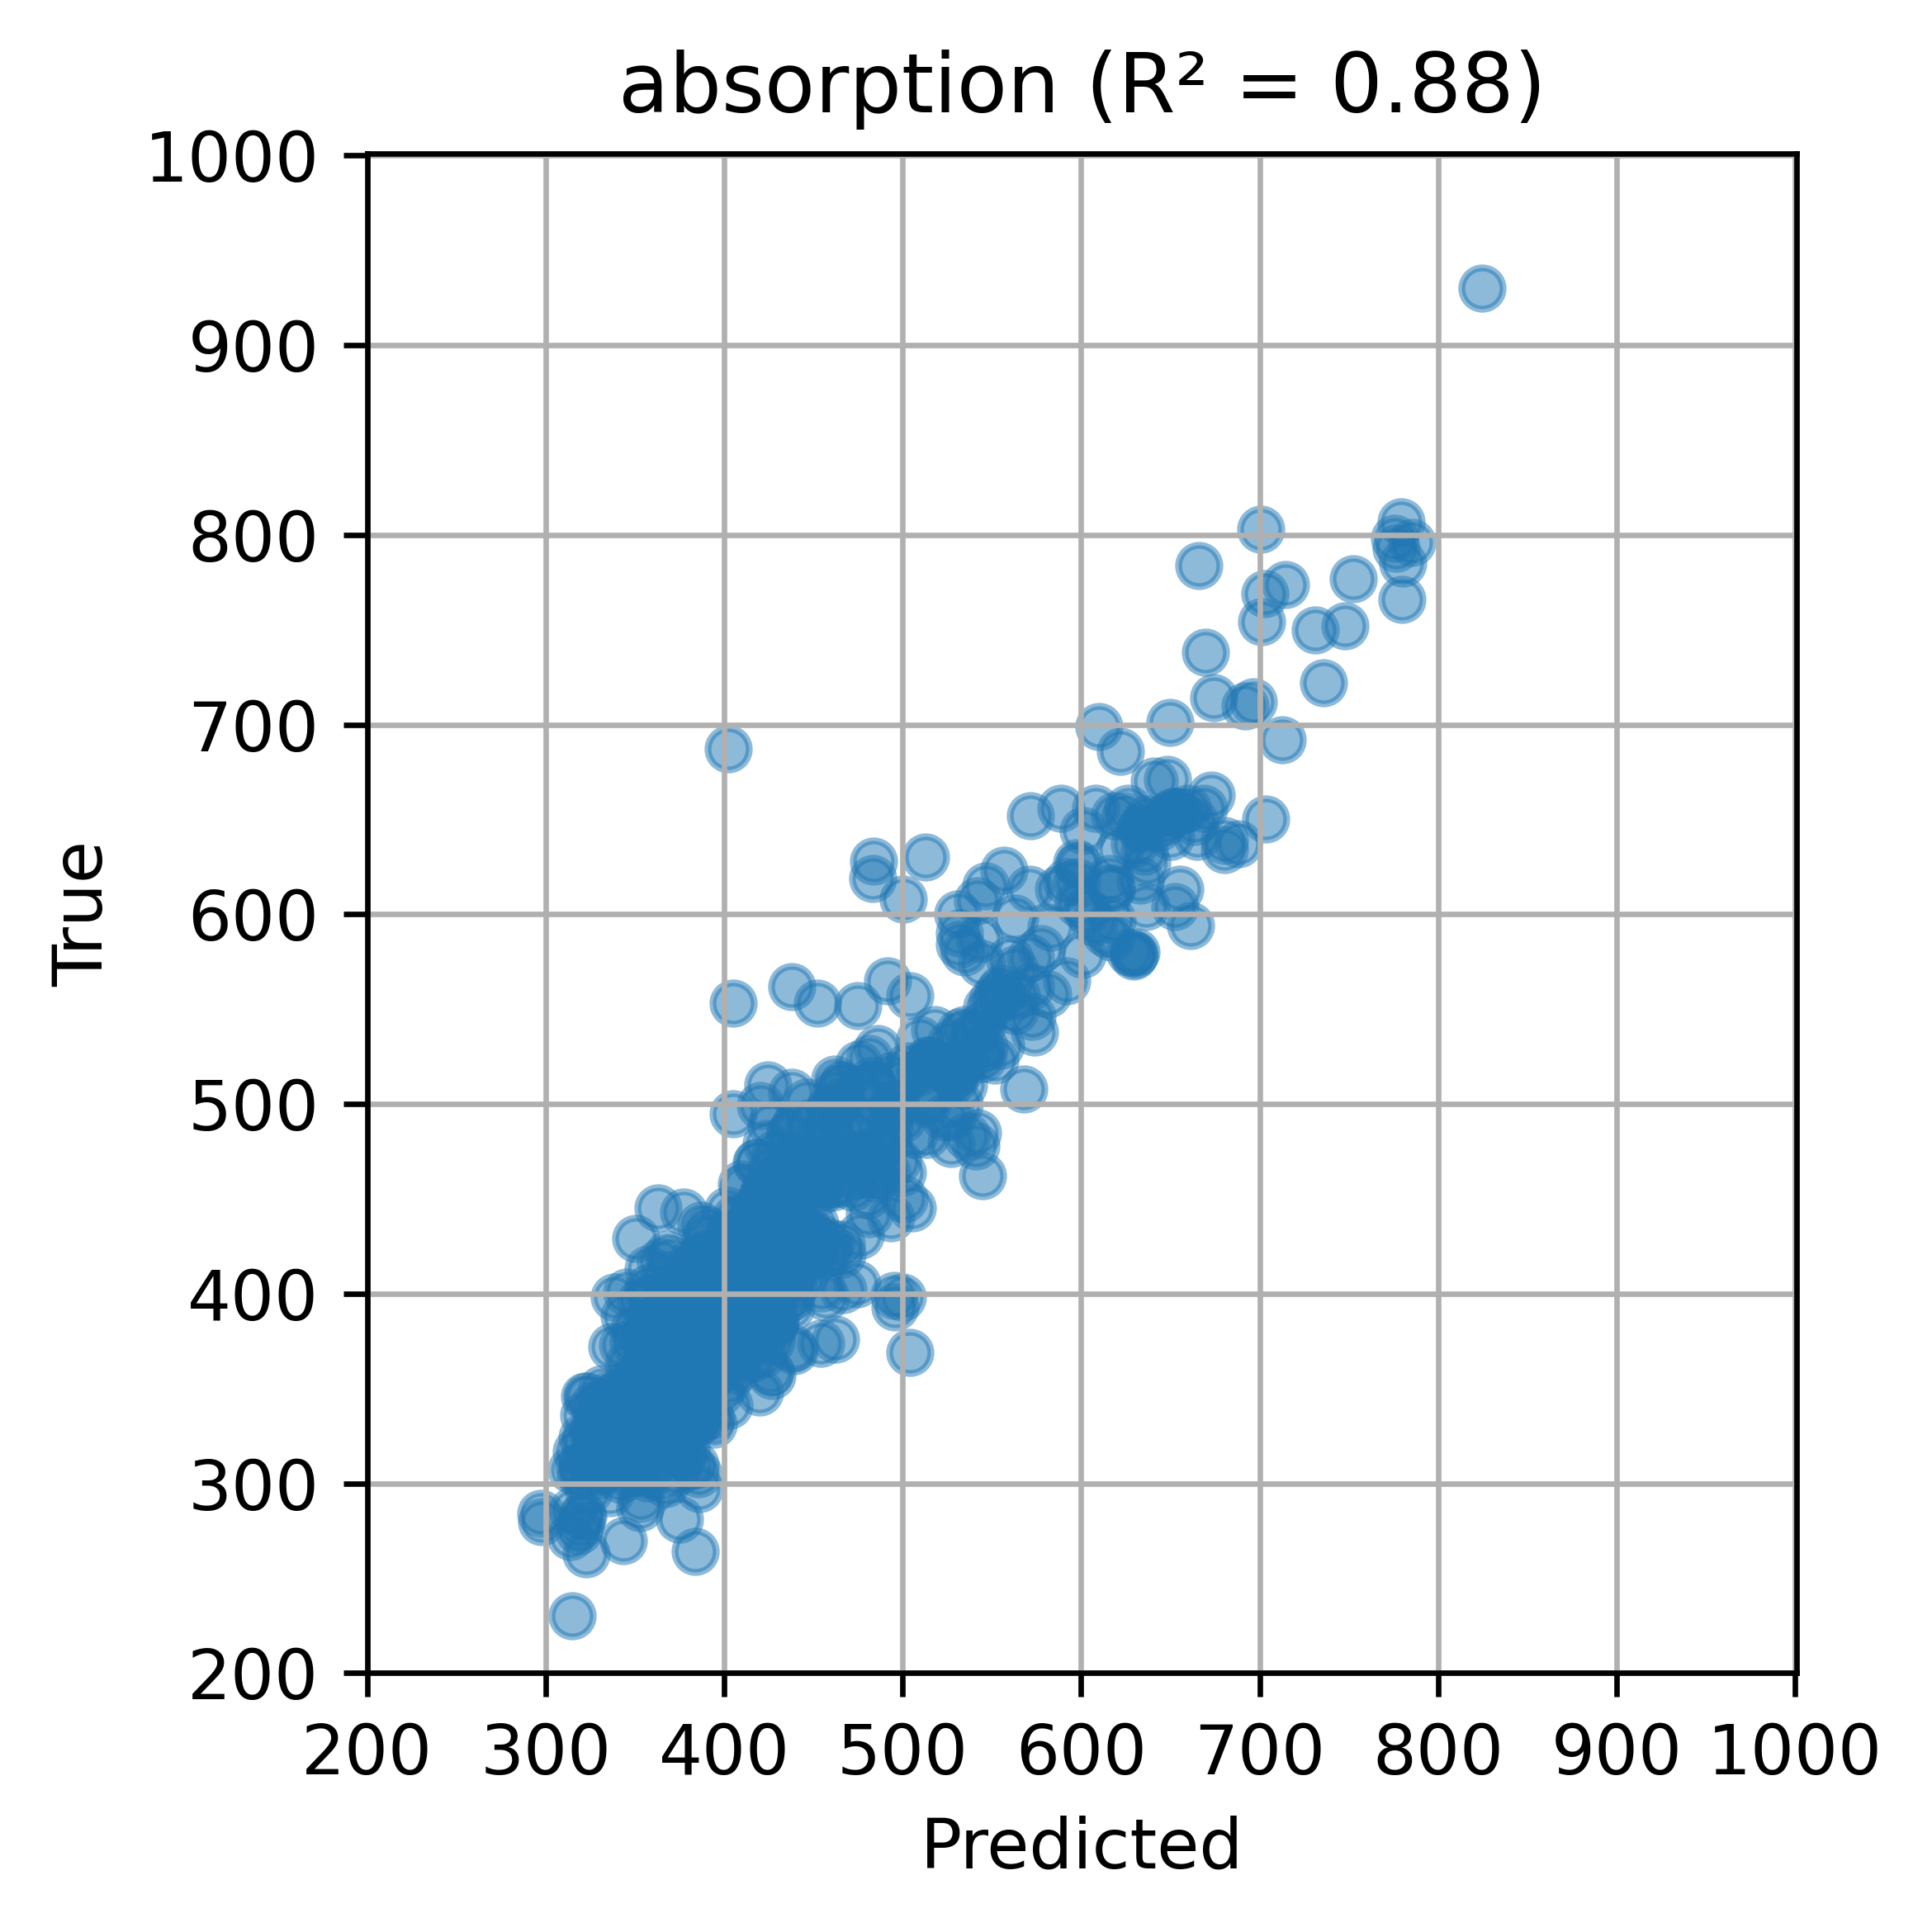

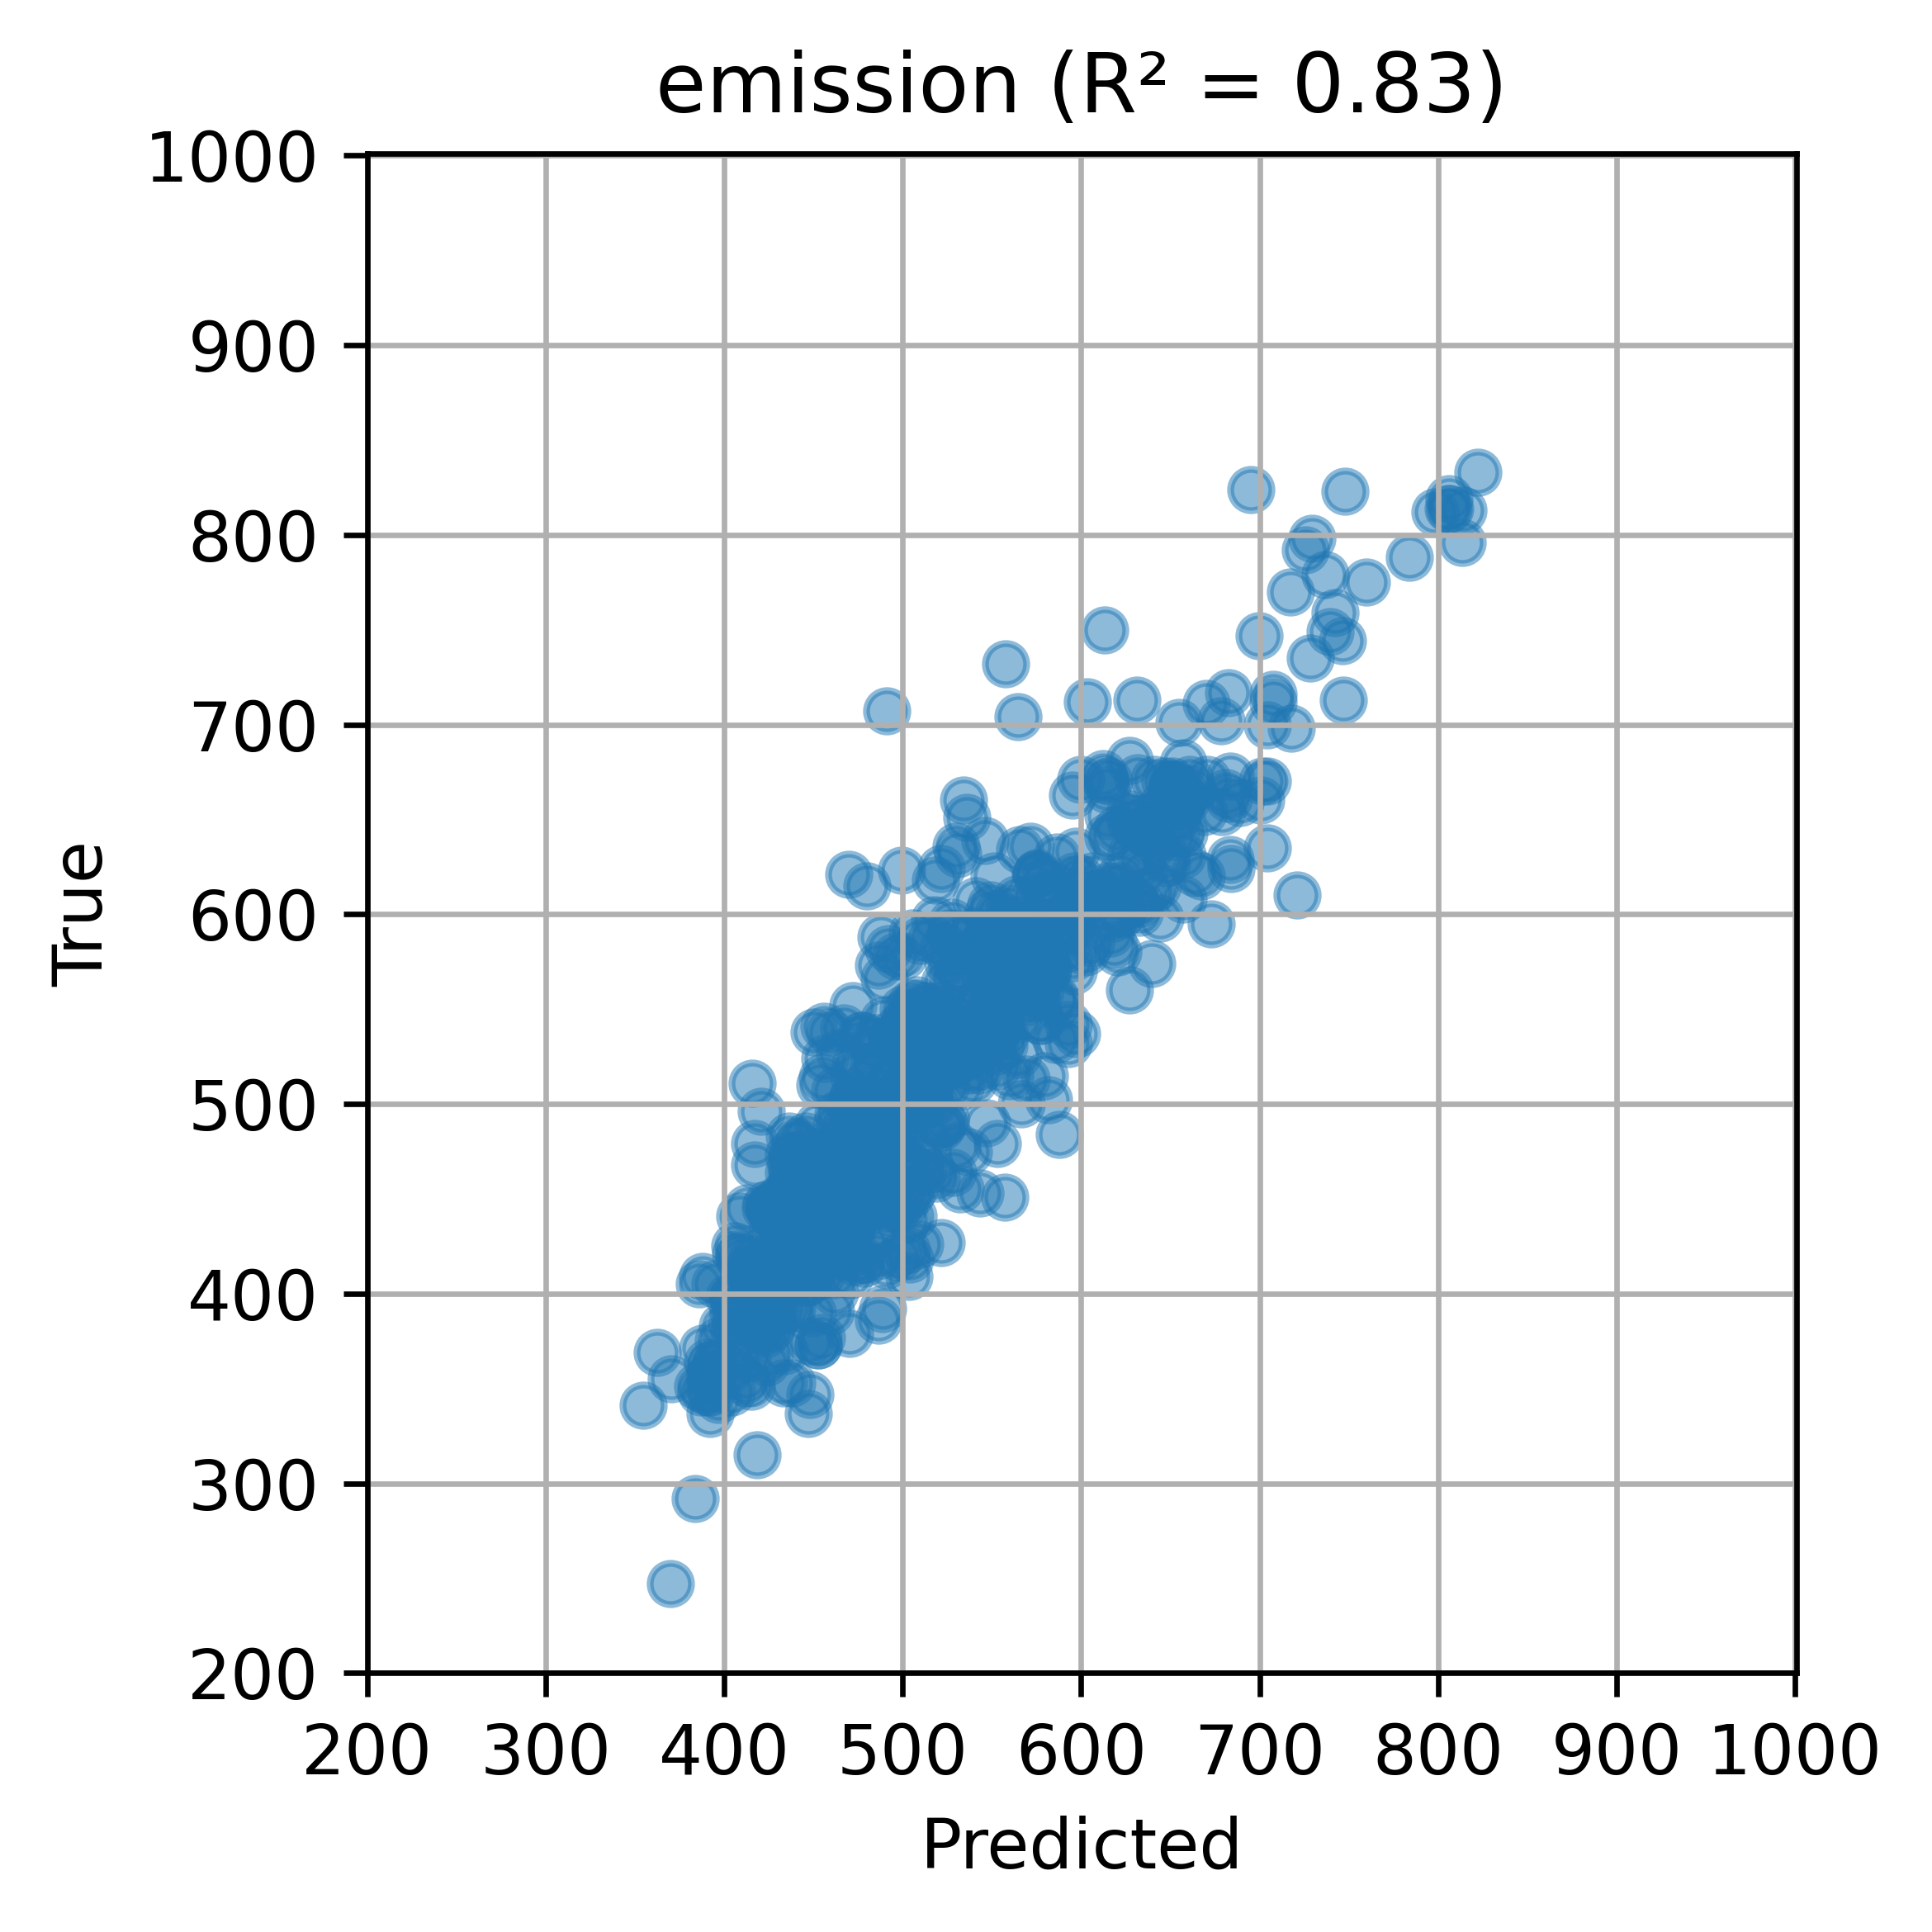

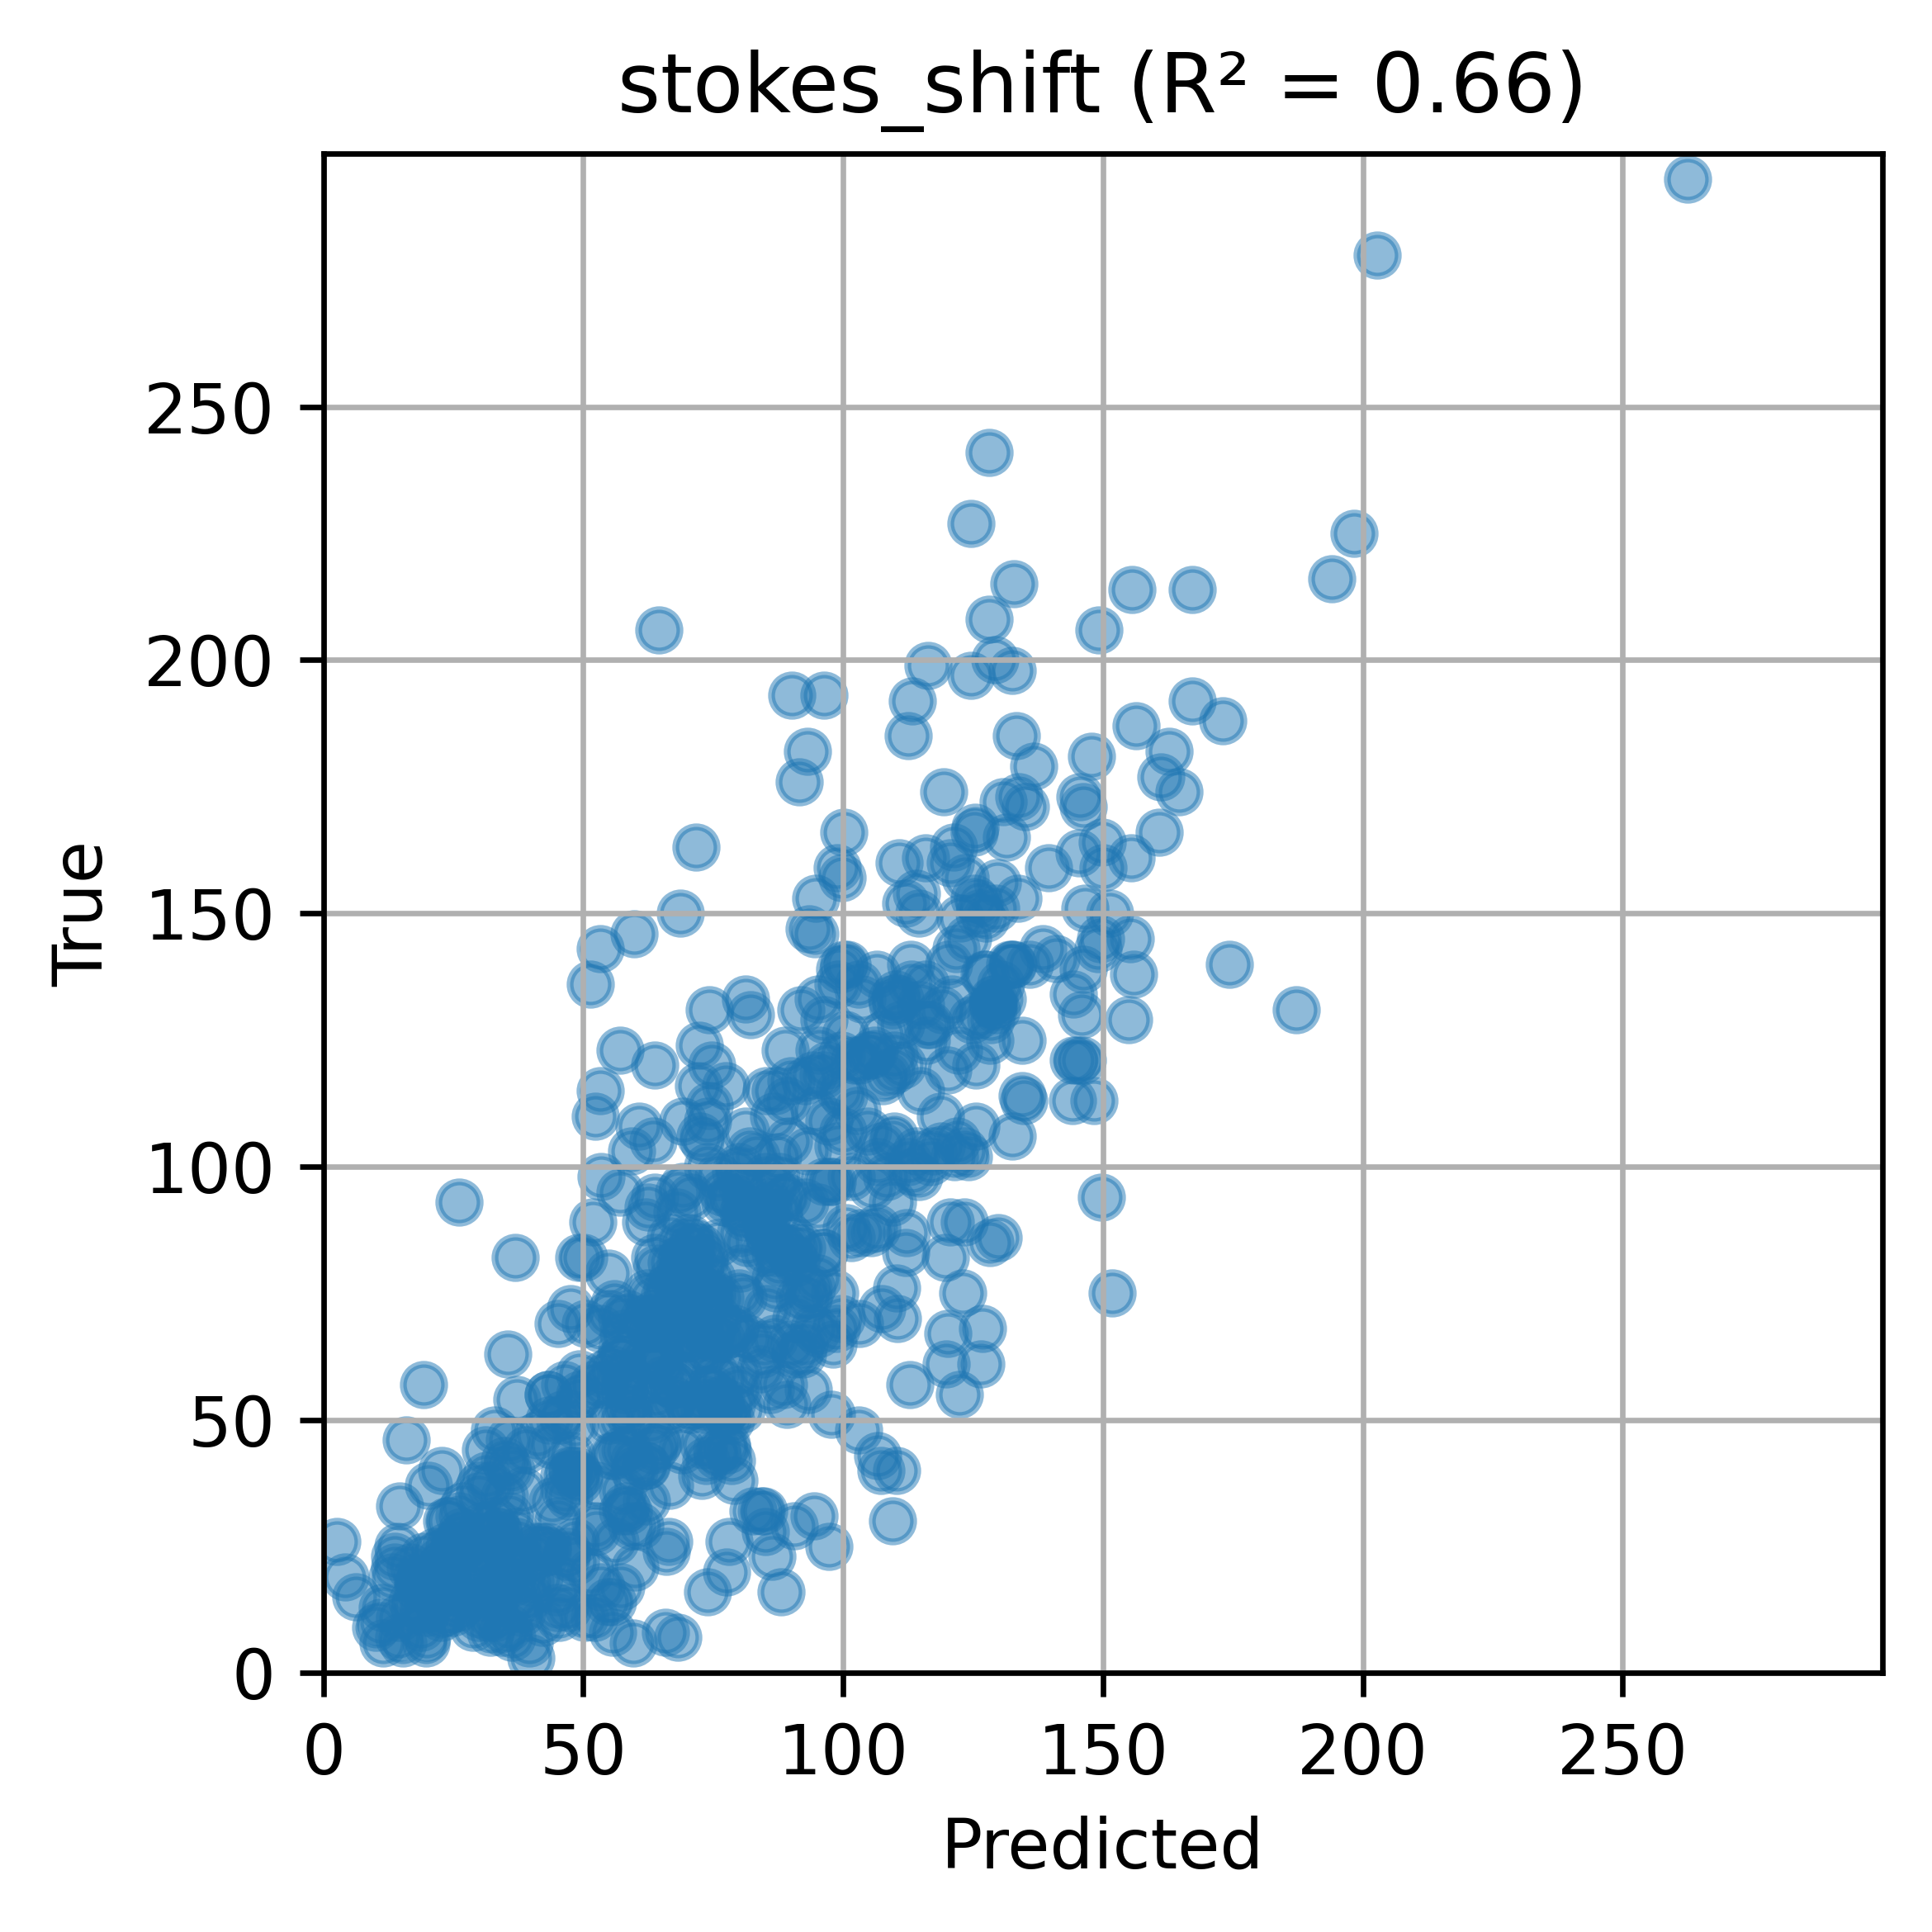

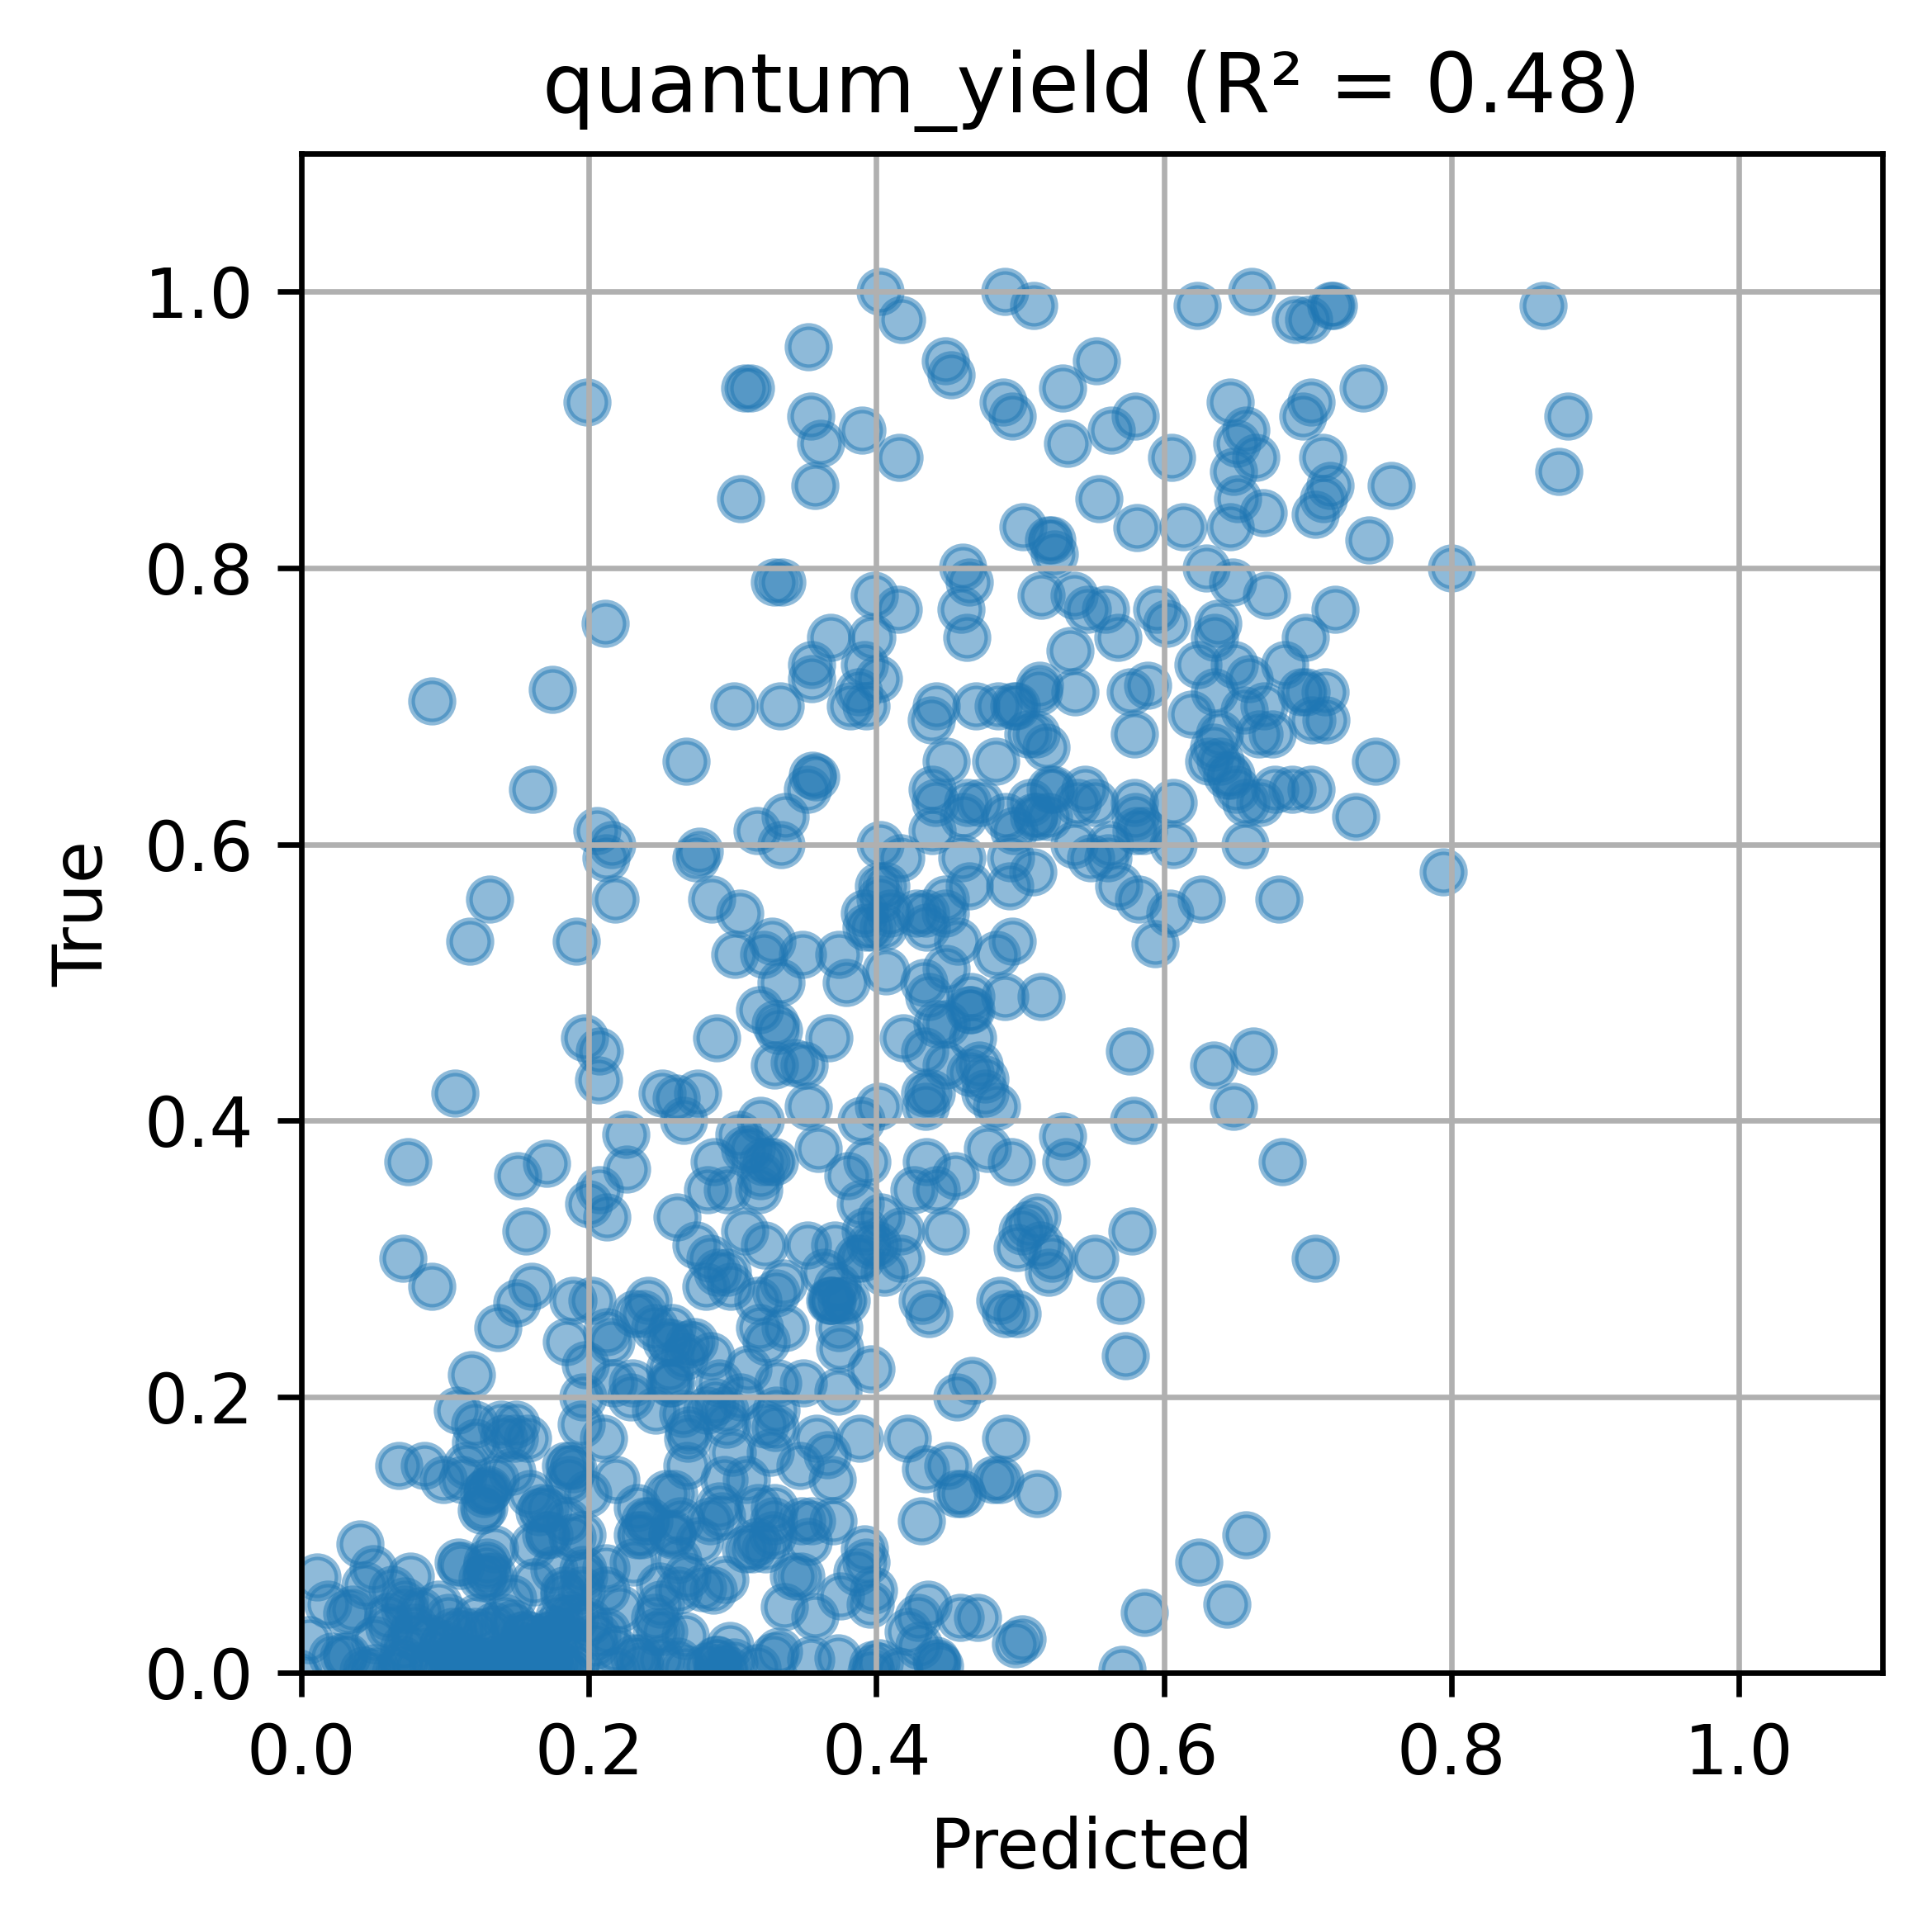

In [ ]:
def plot_r2_scatter_separate(y_true: pd.DataFrame, y_pred: np.ndarray, targets=None, dpi=600):
    """
    分别为每个目标变量绘制独立的 R² 散点图
    """
    if targets is None:
        targets = y_true.columns.tolist()
    
    for i, target in enumerate(targets):
        plt.figure(figsize=(4, 4), dpi=dpi)
        plt.scatter(y_pred[:, i], y_true[target], alpha=0.5)
        r2 = r2_score(y_true[target], y_pred[:, i])
        plt.title(f"{target} (R² = {r2:.2f})")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.grid(True)
        
        # 设置不同目标变量的坐标轴范围
        if target == "absorption" or target == "emission":
            low = 200
            high = 1001
            plt.xlim(low, high)
            plt.ylim(low, high)
            plt.xticks(np.arange(low, high, 100))
            plt.yticks(np.arange(low, high, 100))
        elif target == "stokes_shift":
            low = 0
            high = 300
            plt.xlim(low, high)
            plt.ylim(low, high)
            plt.xticks(np.arange(low, high, 50))
            plt.yticks(np.arange(low, high, 50))
        elif target == "quantum_yield":
            low = 0
            high = 1.1
            plt.xlim(low, high)
            plt.ylim(low, high)
            plt.xticks(np.arange(low, high, 0.2))
            plt.yticks(np.arange(low, high, 0.2))
        else:
            # 如果未定义范围，使用默认的范围
            low = np.min(y_true[target].min(), y_pred[:, i].min())
            high = np.max(y_true[target].max(), y_pred[:, i].max())
        
        
        plt.tight_layout()
        plt.show()

targets = ["absorption", "emission", "stokes_shift", "quantum_yield"]
plot_r2_scatter_separate(y_test, y_pred, targets=targets)

## Shapley

In [9]:
import shap
from rdkit.Chem import Draw

In [ ]:
# 取 absorption 模型 (MultiOutputRegressor 的第一个 estimator_)
absorption_model = model.estimators_[0]
# emission_model = model.estimators_[1]
# stock_model = model.estimators_[2]
# quantum_model = model.estimators_[3]

# 计算 SHAP 值
explainer = shap.TreeExplainer(absorption_model)
X, bitinfos = prepare_features(df)
shap_values = explainer.shap_values(X)

[11:05:51] DEPRECATION WARNING: please use MorganGenerator
[11:05:51] DEPRECATION WARNING: please use MorganGenerator
[11:05:51] DEPRECATION WARNING: please use MorganGenerator
[11:05:51] DEPRECATION WARNING: please use MorganGenerator
[11:05:51] DEPRECATION WARNING: please use MorganGenerator
[11:05:51] DEPRECATION WARNING: please use MorganGenerator
[11:05:51] DEPRECATION WARNING: please use MorganGenerator
[11:05:51] DEPRECATION WARNING: please use MorganGenerator
[11:05:51] DEPRECATION WARNING: please use MorganGenerator
[11:05:51] DEPRECATION WARNING: please use MorganGenerator
[11:05:51] DEPRECATION WARNING: please use MorganGenerator
[11:05:51] DEPRECATION WARNING: please use MorganGenerator
[11:05:51] DEPRECATION WARNING: please use MorganGenerator
[11:05:51] DEPRECATION WARNING: please use MorganGenerator
[11:05:51] DEPRECATION WARNING: please use MorganGenerator
[11:05:51] DEPRECATION WARNING: please use MorganGenerator
[11:05:51] DEPRECATION WARNING: please use MorganGenerat

In [45]:
# 创建保存目录
cache_dir = Path("shapley_case")
cache_dir.mkdir(exist_ok=True)

# 以第一个分子为例
sample_idx = 3344

# 取出该样本的 SHAP 值向量
sample_shap = shap_values[sample_idx]

# 取出最重要的前 N 个 bits
N = 5
important_bits = np.argsort(np.abs(sample_shap))[::-1][:N]

# 取出该分子的 smiles 和 mol
smiles_sample = df.iloc[sample_idx]["smiles"]
mol = Chem.MolFromSmiles(smiles_sample)

# 保存整体分子图片
img = Draw.MolToImage(mol, size=(200, 200))
img.save(cache_dir / f"mol_{sample_idx}.png")

# 取出该分子的 bitinfo
bitinfo_sample = bitinfos[sample_idx]

# 映射每个重要 bit 回 fragment
with open(cache_dir / f"bit_{sample_idx}.txt", "w") as f:
    for bit in important_bits:
        shap_value = sample_shap[bit]
        print(f"Bit {bit}, SHAP value: {shap_value:.4f}")
        f.write(f"Bit {bit}, SHAP value: {shap_value:.4f}\n")

        if bit in bitinfo_sample:
            for i, (atom_idx, radius) in enumerate(bitinfo_sample[bit]):
                env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_idx)
                submol = Chem.PathToSubmol(mol, env)
                smi = Chem.MolToSmiles(submol)
                print(f"    Fragment {i+1}: {smi}")
                f.write(f"    Fragment {i+1}: {smi}\n")
                # 可视化并保存片段
                frag_img = Draw.MolToImage(submol, size=(200, 200))
                frag_img.save(cache_dir / f"fragment_{sample_idx}_bit{bit}_{i+1}.png")
        else:
            print(f"    Bit {bit} not found in bitInfo.")
            f.write(f"    Bit {bit} not found in bitInfo.\n")

Bit 1594, SHAP value: 33.0044
    Fragment 1: C=C(C)C
    Fragment 2: C=C(C)C
Bit 463, SHAP value: -23.1686
    Bit 463 not found in bitInfo.
Bit 1093, SHAP value: 22.5039
    Fragment 1: C=C(c)N
    Fragment 2: C=C(c)N
Bit 139, SHAP value: 16.8742
    Fragment 1: C=C(c)N(CC)C(C)=O
    Fragment 2: C=C(c)N(CC)C(C)=O
Bit 1386, SHAP value: 16.5383
    Fragment 1: CC(=O)O
    Fragment 2: CC(=O)O
